## VAE-CTGAN 생성 데이터 Evaluation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [3]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/train_category.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/test_category.csv"
test_data = pd.read_csv(test_data_path)

## Load original data
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/CTAB-GAN/Fake_Datasets/ctab-gan_300epochs.csv"
fake = pd.read_csv(fake_path, low_memory=False)

In [4]:
fake['loan_status'].value_counts()

loan_status
1    540000
Name: count, dtype: int64

In [ ]:
"""fake['loan_status'] = 1
fake.columns"""

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'grade', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'loan_amnt',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [5]:
for col in data.columns:
    print(f"{col} feature\n{data[col].unique()}")

last_fico_range_high feature
[744. 739. 614. 604. 654. 804. 824. 659. 559. 724. 769. 589. 499. 694.
 584. 719. 689. 669. 779. 684. 674. 749. 649. 664. 734. 639. 634. 594.
 619. 544. 699. 679. 759. 729. 784. 709. 549. 629. 704. 564. 579. 529.
 569. 714. 754. 599. 764. 539. 574. 534. 519. 524. 644. 814. 609. 794.
 789. 829. 774. 799. 514. 819. 834. 509. 624. 839. 554. 809. 504. 844.
 850.   0.]
annual_inc feature
[50000.  60000.  75000.  ... 31235.  75388.  13235.5]
dti feature
[  4.66  16.14  24.67 ...  97.94  56.6  131.58]
mo_sin_old_rev_tl_op feature
[126.         151.         292.         206.         424.
 114.         308.         131.         275.         315.
 150.         365.         105.         333.         161.
 157.          95.         321.          81.         135.
 130.         117.         102.         223.         503.
 178.          56.         103.         199.         137.
 123.         138.          29.         189.         187.
  30.         118.         186.     

In [6]:
for col in fake.columns:
    print(f"{col} feature\n{fake[col].unique()}")

last_fico_range_high feature
[588.52716064 622.84777832 572.66210938 ... 538.04058838 548.77301025
 577.70477295]
annual_inc feature
[ 59913.4010151  125116.12995925  76284.44402247 ... 100511.73153711
 131501.7286333   69681.93799298]
dti feature
[31.97755241 22.7747097   9.07620811 ...  7.08187103 18.86919975
 32.90359879]
mo_sin_old_rev_tl_op feature
[491.14123535 180.80357361 227.1492157  ... 249.80738831 122.66196442
 104.29493713]
revol_util feature
[0.91608548 0.88258857 0.73302114 ... 0.6582467  0.82527739 0.12090185]
int_rate feature
[0.21219378 0.24101849 0.12248652 ... 0.10536653 0.22042376 0.12343383]
installment feature
[199.903403   992.07639451 305.20274656 ... 931.71846809 837.75231591
 618.55986789]
avg_cur_bal feature
[ 2459.48032904 14260.67805531 11280.68193404 ... 10469.67587526
 24059.95443353  3493.34003392]
revol_bal feature
[25057.29879009 18079.37508121  7799.19453549 ... 18689.42833283
   651.75032142 11277.45715148]
debt_settlement_flag feature
['N' 'Y']
sub

In [8]:
fake['term_months'].value_counts()

term_months
36    308441
60    231559
Name: count, dtype: int64

In [60]:
## term_months 오류 수정
fake['term_months'] = fake['term_months'].apply(lambda x : 36 if abs(x-36)<=abs(x-60) else 60)

In [61]:
fake['term_months'].value_counts()

term_months
36    325919
60    214081
Name: count, dtype: int64

In [8]:
data.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'grade', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'loan_amnt',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [9]:
#keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
data_classification = data.copy()
test_classification = test_data.copy()
fake_classification = fake.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)
fake_classification = fake_classification.drop(columns = keep_features)

In [11]:
data_classification.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [10]:
fake_classification.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [12]:
## data Encoding
Labelencoding_features = ['term_months', 'sub_grade']
onehot_features = ['debt_settlement_flag', 'home_ownership', 'purpose']

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

label_encoders = {}
for col in Labelencoding_features:
    le = LabelEncoder()
    data_classification[col] = le.fit_transform(data_classification[col])
    label_encoders[col] = le

# One-Hot Encoding
onehot_encoded = onehot_encoder.fit_transform(data_classification[onehot_features])
onehot_encoded_df = pd.DataFrame(
    onehot_encoded, 
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=data_classification.index
)

# Merge
data_classification.drop(columns=onehot_features, inplace=True)
data_classification = pd.concat([data_classification, onehot_encoded_df], axis=1)

print("✅ Encoding 완료! 결과 shape:", data_classification.shape)

✅ Encoding 완료! 결과 shape: (1116458, 35)


In [13]:
##Fake data encoding
for col in Labelencoding_features:
    le = label_encoders[col]
    fake_classification[col] = le.transform(fake_classification[col])

# One-Hot Encoding (train에서 fit된 onehot_encoder 재사용)
onehot_encoded_test = onehot_encoder.transform(fake_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=fake_classification.index
)

# Merge
fake_classification.drop(columns=onehot_features, inplace=True)
fake_classification = pd.concat([fake_classification, onehot_encoded_test_df], axis=1)

print("✅ 테스트 데이터 인코딩 완료! 결과 shape:", fake_classification.shape)

##Test data encoding
for col in Labelencoding_features:
    le = label_encoders[col]
    test_classification[col] = le.transform(test_classification[col])

# One-Hot Encoding (train에서 fit된 onehot_encoder 재사용)
onehot_encoded_test = onehot_encoder.transform(test_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=test_classification.index
)

# Merge
test_classification.drop(columns=onehot_features, inplace=True)
test_classification = pd.concat([test_classification, onehot_encoded_test_df], axis=1)

print("✅ 테스트 데이터 인코딩 완료! 결과 shape:", test_classification.shape)

✅ 테스트 데이터 인코딩 완료! 결과 shape: (540000, 35)
✅ 테스트 데이터 인코딩 완료! 결과 shape: (744306, 35)


In [14]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, train_size=0.8, test_size=0.2, random_state=42, stratify=data_y)

train_classification = pd.concat([X_train, y_train], axis=1)

In [15]:
from sklearn.utils import shuffle

train_data = pd.concat([train_classification, fake_classification])
train_data['loan_status'].value_counts()
train_data = shuffle(train_data, random_state=42)

In [16]:
train_data['loan_status'].value_counts()

loan_status
0    718935
1    714231
Name: count, dtype: int64

In [17]:
X_train = train_data.drop(columns='loan_status')
y_train = train_data[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

model = XGBClassifier( 
    n_estimators=500,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68599	validation_1-logloss:0.68433
[1]	validation_0-logloss:0.67899	validation_1-logloss:0.67765
[2]	validation_0-logloss:0.67212	validation_1-logloss:0.67109
[3]	validation_0-logloss:0.66535	validation_1-logloss:0.66466
[4]	validation_0-logloss:0.65875	validation_1-logloss:0.65835
[5]	validation_0-logloss:0.65224	validation_1-logloss:0.65216
[6]	validation_0-logloss:0.64588	validation_1-logloss:0.64609
[7]	validation_0-logloss:0.63974	validation_1-logloss:0.64022
[8]	validation_0-logloss:0.63361	validation_1-logloss:0.63436
[9]	validation_0-logloss:0.62768	validation_1-logloss:0.62869
[10]	validation_0-logloss:0.62177	validation_1-logloss:0.62306
[11]	validation_0-logloss:0.61608	validation_1-logloss:0.61760
[12]	validation_0-logloss:0.61040	validation_1-logloss:0.61219
[13]	validation_0-logloss:0.60483	validation_1-logloss:0.60687
[14]	validation_0-logloss:0.59944	validation_1-logloss:0.60172
[15]	validation_0-logloss:0.59407	validation_1-logloss:0.59659
[1

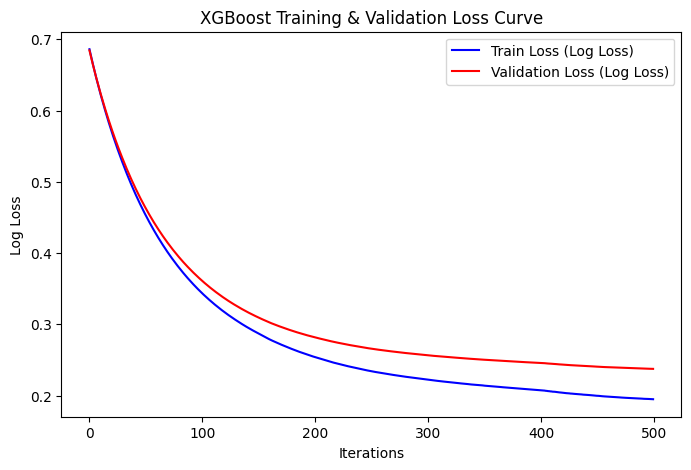

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93    599114
           1       0.69      0.86      0.77    145192

    accuracy                           0.90    744306
   macro avg       0.83      0.88      0.85    744306
weighted avg       0.91      0.90      0.90    744306



In [19]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [20]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[543286  55828]
 [ 19874 125318]]

True Positives (TP): 125318
False Positives (FP): 55828
True Negatives (TN): 543286
False Negatives (FN): 19874


## VAE-CTGAN 생성 데이터 Portfolio

In [21]:
def encode_features(df, label_encoders, onehot_encoder, label_cols, onehot_cols):
    df = df.copy()
    
    # Label Encoding
    for col in label_cols:
        le = label_encoders[col]
        df[col] = le.transform(df[col])

    # One-Hot Encoding
    onehot_encoded = onehot_encoder.transform(df[onehot_cols])
    onehot_df = pd.DataFrame(
        onehot_encoded, 
        columns=onehot_encoder.get_feature_names_out(onehot_cols),
        index=df.index
    )

    df.drop(columns=onehot_cols, inplace=True)
    df = pd.concat([df, onehot_df], axis=1)
    
    return df

In [22]:
summary_with_sharpe = []

def linear_portfolio(top_10_indices):
    selected = test_data.loc[top_10_indices.index].copy()
    returns = (selected['total_pymnt_inv'] - selected['loan_amnt']) / selected['loan_amnt']
    
    avg_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = avg_return / std_return if std_return != 0 else np.nan

    summary_with_sharpe.append({
        'Average Return': avg_return * 100,
        'Std Dev': std_return,
        'Sharpe Ratio': sharpe_ratio
    }) 

In [20]:
data.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'grade', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'loan_amnt',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [23]:
drop2 = ['loan_status', 'return']

scaler = StandardScaler()
reg = LinearRegression()

fully_paid_indices = (y_pred == 0)
test_regression = test_data[fully_paid_indices]
test_regression['return'] = (test_regression['total_pymnt_inv'] - test_regression['funded_amnt'])/test_regression['funded_amnt']

train_regression = data.copy()

train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']

drop_features = ['loan_status', 'total_pymnt_inv', 'total_pymnt','funded_amnt','grade','loan_amnt']
train_regression = train_regression.drop(columns=drop_features)
test_regression = test_regression.drop(columns=drop_features)

fake_regression = fake.copy()

fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
fake_regression = fake_regression.drop(columns=drop_features)

train_total = pd.concat([train_regression, fake_regression])

########## Encoding categorical data ######################
train_total = encode_features(train_total, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

data_x = train_total.drop(columns='return')
data_y = train_total[['return']]

test_x = test_regression.drop(columns = 'return')
test_y = test_regression[['return']]

data_x_scaled = scaler.fit_transform(data_x)

X_train = data_x_scaled
y_train = data_y

test_x_scaled = scaler.transform(test_x)

reg.fit(X_train, y_train)

#print(reg.coef_)
y_pred = reg.predict(test_x_scaled)

print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
print("R²:", r2_score(test_y, y_pred))

test_regression['predicted_return'] = reg.predict(test_x_scaled)
top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

linear_portfolio(top_10_percent)

RMSE: 0.32077744637990263
R²: -2.4169530751257757


In [24]:
returns_with_sharpe_df = pd.DataFrame(summary_with_sharpe)

returns_with_sharpe_df.head()

,Average Return,Std Dev,Sharpe Ratio
0,16.672852,0.185617,0.898239


## Analysis between Original and VAE-TableGAN Samples

In [25]:
label1_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/train_category_1.csv"
label1_data = pd.read_csv(label1_data_path, low_memory=False)

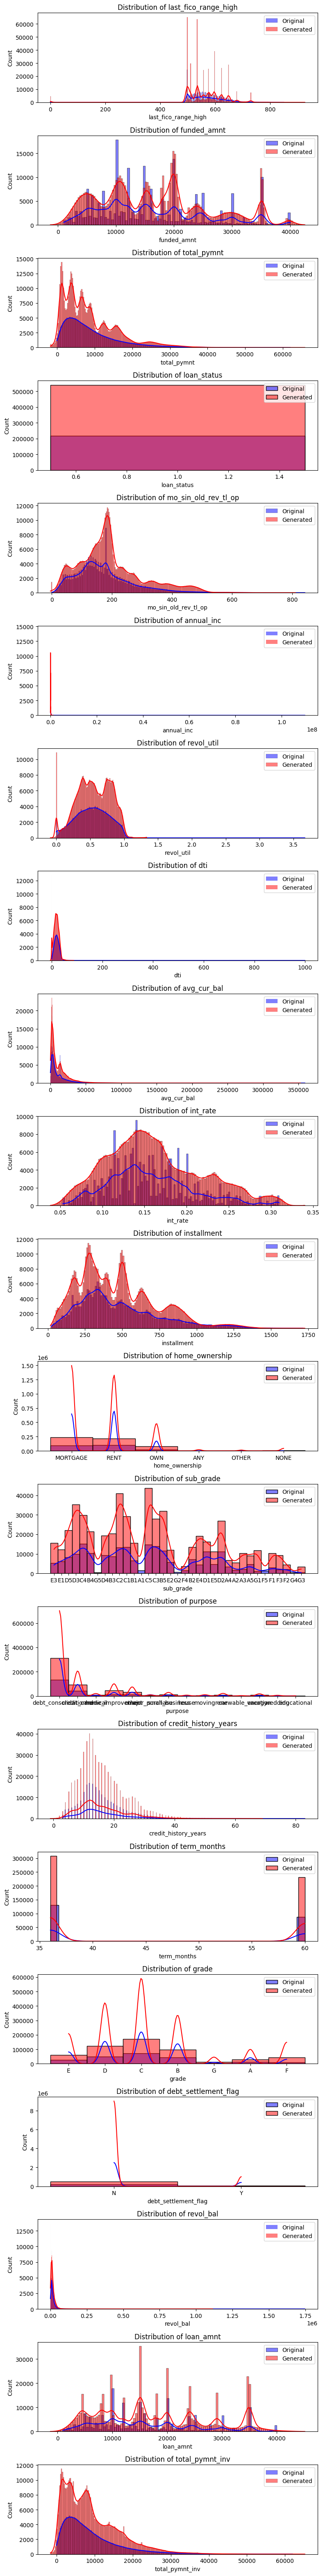

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 원본 데이터와 TableGAN 생성 데이터 불러오기
# 원본 데이터: original_df
# TableGAN이 생성한 데이터: generated_df

# 공통 feature 선택 (혹시 컬럼이 다를 수도 있으니)
common_features = list(set(data.columns) & set(fake.columns))
original_df = label1_data[common_features]
generated_df = fake[common_features]

# ------------------------------
# 1️⃣ 히스토그램 비교 (각 feature 분포)
# ------------------------------
num_features = len(common_features)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, num_features * 3))

for i, feature in enumerate(common_features):
    sns.histplot(original_df[feature], color='blue', label='Original', kde=True, ax=axes[i], alpha=0.5)
    sns.histplot(generated_df[feature], color='red', label='Generated', kde=True, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [27]:
label1_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217789 entries, 0 to 217788
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   last_fico_range_high  217789 non-null  float64
 1   annual_inc            217789 non-null  float64
 2   dti                   217789 non-null  float64
 3   mo_sin_old_rev_tl_op  217789 non-null  float64
 4   revol_util            217789 non-null  float64
 5   int_rate              217789 non-null  float64
 6   installment           217789 non-null  float64
 7   avg_cur_bal           217789 non-null  float64
 8   revol_bal             217789 non-null  float64
 9   debt_settlement_flag  217789 non-null  object 
 10  sub_grade             217789 non-null  object 
 11  home_ownership        217789 non-null  object 
 12  purpose               217789 non-null  object 
 13  grade                 217789 non-null  object 
 14  total_pymnt           217789 non-null  float64
 15  

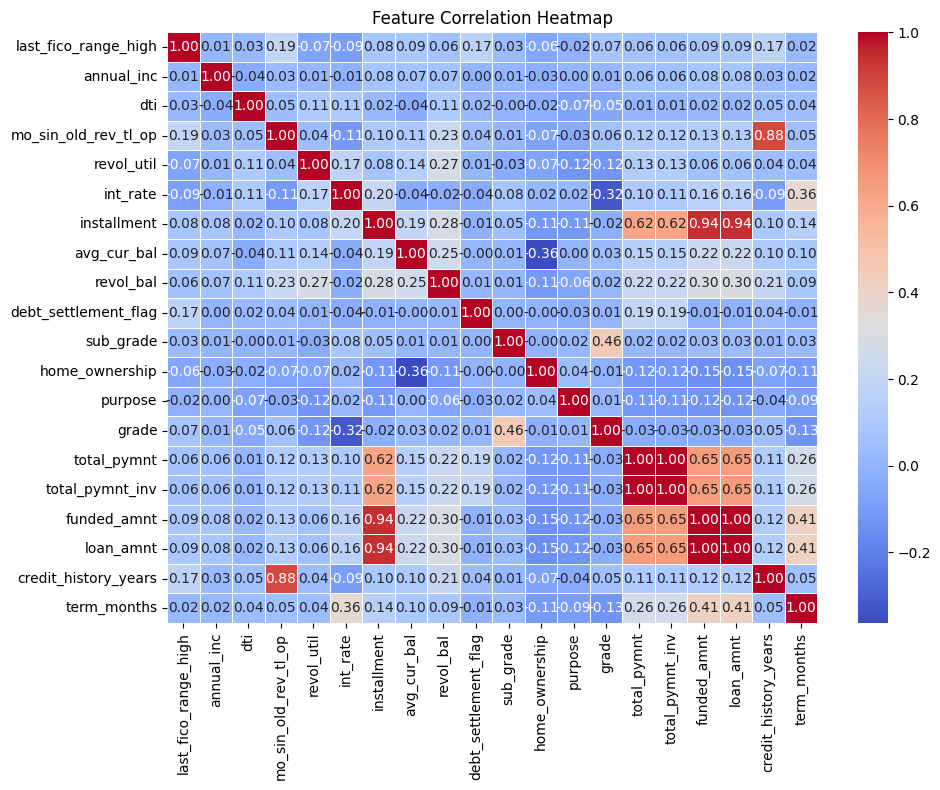

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = label1_data.copy()

if 'loan_status' in df.columns:
    df = df.drop(columns=['loan_status'])

# 문자열 → 숫자 변환 (필요시)
for col in df.select_dtypes(include='object').columns:
    df[col] = pd.factorize(df[col])[0]

corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()

plt.savefig("correlation_heatmap.png", dpi=300)

plt.show()
